### Environment and library settings

In [20]:
from pathlib import Path
from PIL import Image, ImageShow
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import cv2
from skimage.transform import resize
from tifffile import imread
import time

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [3]:
!pwd

/home/jupyter


In [4]:
import os
os.listdir('/home/jupyter')

['.config',
 '.nv',
 '.ipython',
 'bigearthnet_model_Resnet50v2-RGB60_epochs2.ipynb',
 '.cache',
 '.jupyter',
 'bigearthnet_model_Resnet50v2-RGB60_plus_all_NIRs_SWIRs_epochs2.ipynb',
 'data',
 'tutorials',
 '.bash_history',
 '.ipynb_checkpoints',
 '.local',
 'bigearthnet_model_Resnet50v2_RGB120_epochs2.ipynb',
 '.keras',
 'exploration.ipynb',
 'bigearthnet_model.ipynb',
 'check_gpu.ipynb',
 '.docker']

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
next(os.walk('/home/jupyter/data/BigEarthNet-v1.0'))[1][0]

'S2A_MSIL2A_20170617T113321_26_63'

In [7]:
os.listdir('/home/jupyter/data/BigEarthNet-v1.0/S2B_MSIL2A_20180525T94030_55_37/')

['S2B_MSIL2A_20180525T94030_55_37_B06.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B05.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B02.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B8A.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B12.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B03.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B04.tif',
 'S2B_MSIL2A_20180525T94030_55_37_labels_metadata.json',
 'S2B_MSIL2A_20180525T94030_55_37_B08.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B01.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B11.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B09.tif',
 'S2B_MSIL2A_20180525T94030_55_37_B07.tif']

In [8]:
data_dir = "/home/jupyter/data/BigEarthNet-v1.0"

In [9]:
img_list = os.listdir(data_dir)
img_list[0:10]

['S2A_MSIL2A_20170617T113321_26_63',
 'S2B_MSIL2A_20170930T095019_61_18',
 'S2B_MSIL2A_20180421T100030_47_74',
 'S2A_MSIL2A_20171002T094031_82_49',
 'S2B_MSIL2A_20180511T100029_37_18',
 'S2A_MSIL2A_20171002T112111_36_14',
 'S2B_MSIL2A_20180525T94030_55_37',
 'S2A_MSIL2A_20180225T114351_15_84',
 'S2A_MSIL2A_20180506T100031_85_20',
 'S2A_MSIL2A_20171101T094131_25_54']

In [10]:
print("The total image patches ", len(os.listdir(data_dir)))

The total image patches  590326


### Configuring the model parameters and constant variables

In [11]:
PIXEL = 120
BATCH_SIZE = 32
BATCH_COUNT = len(img_list)//BATCH_SIZE
CHANNELS = ["B04","B03","B02"]

# B01: Coastal aerosol; 60m
# B02: Blue; 10m
# B03: Green; 10m
# B04: Red; 10m
# B05: Vegetation red edge; 20m
# B06: Vegetation red edge; 20m
# B07: Vegetation red edge; 20m
# B08: NIR; 10m
# B09: Water vapor; 60m
# B11: SWIR; 20m
# B12: SWIR; 20m
# B8A: Narrow NIR; 20m

LABEL_MAP = {'Agro-forestry areas':1,
           'Airports':0,
           'Annual crops associated with permanent crops':1,
           'Bare rock':0,
           'Beaches, dunes, sands':0,
           'Broad-leaved forest':0,
           'Burnt areas':0,
           'Coastal lagoons':0,
           'Complex cultivation patterns':1,
           'Coniferous forest':0,
           'Construction sites':0,
           'Continuous urban fabric':0,
           'Discontinuous urban fabric':0,
           'Dump sites':0,
           'Estuaries':0,
           'Fruit trees and berry plantations':1,
           'Green urban areas':0,
           'Industrial or commercial units':0,
           'Inland marshes':0,
           'Intertidal flats':0,
           'Land principally occupied by agriculture, with significant areas of natural vegetation':1,
           'Mineral extraction sites':0,
           'Mixed forest':0,
           'Moors and heathland':0,
           'Natural grassland':0,
           'Non-irrigated arable land':0,
           'Olive groves':1,
           'Pastures':1,
           'Peatbogs':0,
           'Permanently irrigated land':1,
           'Port areas':0,
           'Rice fields':1,
           'Road and rail networks and associated land':0,
           'Salines':0,
           'Salt marshes':0,
           'Sclerophyllous vegetation':0,
           'Sea and ocean':0,
           'Sparsely vegetated areas':0,
           'Sport and leisure facilities':0,
           'Transitional woodland/shrub':0,
           'Vineyards':1,
           'Water bodies':0,
           'Water courses':0
           }

In [12]:
### custom data generator to be used for the stacking approach

class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data_dir, img_list, label_map, shuffle, channels, batch_size, pixel):
        self.img_list = img_list
        self.data_dir = data_dir
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.label_map = label_map
        self.__on_epoch_end()
        self.channels = channels
        self.pixel = pixel
        # print(channels)

    def __len__(self):
        # denote the number of batches in an epoch
        return int(np.floor(len(self.img_list))/self.batch_size)

    def __on_epoch_end(self):
        'create and update index of the images in each epoch'
        self.indexes = np.arange(len(self.img_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        img_list = [self.img_list[i] for i in indexes]
        imgs = [self.__load_img(img_path) for img_path in img_list]
        # label = [1 for img_path in img_list]
        labels =[]

        for img_path in img_list:
            label = self.__generate_label(img_path, self.data_dir, self.label_map)
            labels.append(label)

        imgs = np.array(imgs)
        labels = np.array(labels)

        return imgs, labels


    def __generate_label(self, img_path, data_dir, label_map):
  
        # unroll Json to get label
        label_path = os.path.join(data_dir, img_path, img_path + '_labels_metadata.json')
        label_data = json.load(open(label_path))

        for i in label_data["labels"]:
            if label_map[i]==1:
                return 1

        return 0


    def __load_img(self, img_path):

        ch_img_list = []

        for ch in self.channels:
            ch_path = os.path.join(data_dir, img_path, img_path + '_' + ch + '.tif')
            ch_img_list.append(imread(ch_path))

        img = self.__preprocess(ch_img_list)

        return img

    def __preprocess(self, channels):

        'preprocess and resize channels'

        # dimension
        dim = (self.pixel,self.pixel)
        list_of_ch = []

        for k in channels:
            mat = cv2.resize(np.array(k), dim)

            #print(np.array(k).shape)
            list_of_ch.append(mat)

        img = np.dstack(list_of_ch)

        return img

In [13]:
data_gen = Dataset(data_dir, img_list, LABEL_MAP, True, CHANNELS, BATCH_SIZE, PIXEL)

In [15]:
data_gen.__getitem__(0)

(array([[[[ 709,  865,  490],
          [ 682,  848,  490],
          [ 673,  830,  490],
          ...,
          [ 513,  687,  425],
          [ 506,  689,  423],
          [ 571,  758,  426]],
 
         [[ 669,  833,  488],
          [ 682,  824,  470],
          [ 680,  850,  454],
          ...,
          [ 492,  660,  422],
          [ 494,  703,  407],
          [ 595,  710,  413]],
 
         [[ 644,  830,  464],
          [ 649,  819,  492],
          [ 660,  852,  493],
          ...,
          [ 493,  663,  410],
          [ 505,  695,  417],
          [ 617,  732,  457]],
 
         ...,
 
         [[ 766,  804,  503],
          [ 648,  738,  443],
          [ 599,  767,  477],
          ...,
          [ 899, 1046,  666],
          [ 865, 1051,  674],
          [ 843, 1030,  636]],
 
         [[ 760,  778,  530],
          [ 652,  709,  461],
          [ 599,  731,  458],
          ...,
          [ 907, 1060,  702],
          [ 917, 1076,  673],
          [ 875, 1061,  646

In [14]:
img, label = data_gen.__getitem__(0)

In [15]:
print(img.shape)
print(label.shape)

(32, 120, 120, 3)
(32,)


In [16]:
## Model setup

orig_model = tf.keras.applications.ResNet50V2(include_top=True, weights=None, pooling = "avg", classes=1, classifier_activation='sigmoid')
if len(CHANNELS) >= 9:

  # apply 2 additional feature maps (i.e., conv layers) to
  # graudally step down the informational filtering
  # why >= 9? because it's 3^2 
    dense_input = tf.keras.layers.Input(shape=(PIXEL, PIXEL, len(CHANNELS)))
    dense_filter = tf.keras.layers.Conv2D(6, 3, padding='same')(dense_input)
    dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
    out = orig_model(dense_filter)
elif len(CHANNELS) > 3:
    dense_input = tf.keras.layers.Input(shape=(PIXEL, PIXEL, len(CHANNELS)))
    dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
    out = orig_model(dense_filter)
else:
    dense_input = tf.keras.layers.Input(shape=(PIXEL, PIXEL, 3))
    out = orig_model(dense_input)

model = tf.keras.Model(dense_input, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1)                 23566849  
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [17]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])

### Data split and model training

In [18]:
# split train and test datasets
train_list = img_list[:int(len(img_list)*0.8)]
test_list = img_list[int(len(img_list)*0.8):]

data_train = Dataset(data_dir, train_list, LABEL_MAP, True, CHANNELS, BATCH_SIZE, PIXEL)
data_test = Dataset(data_dir, test_list, LABEL_MAP, False, CHANNELS, BATCH_SIZE, PIXEL)

In [ ]:
start_time = time.time()
history = model.fit(data_train, validation_data=data_test, epochs=2)

Epoch 1/2
 5081/14758 [=========>....................] - ETA: 3:40:54 - loss: 0.4978 - accuracy: 0.7648 - precision: 0.7428 - recall: 0.7996

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12272/14758 [=======================>......] - ETA: 56:56 - loss: 0.4657 - accuracy: 0.7813 - precision: 0.7608 - recall: 0.8100

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3422/14758 [=====>........................] - ETA: 4:14:21 - loss: 0.4099 - accuracy: 0.8104 - precision: 0.7942 - recall: 0.8289

In [24]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("training completed")

--- 50004.78706455231 seconds ---
training completed


In [25]:
start_time = time.time()
evaluation = model.evaluate(data_test, batch_size=BATCH_SIZE)

3689/3689 [==============================] - 4927s 1s/step - loss: 0.4210 - accuracy: 0.7868 - precision: 0.8720 - recall: 0.6629


In [26]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("evaluation completed")

--- 4928.553035736084 seconds ---
evaluation completed


### Training outcome

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


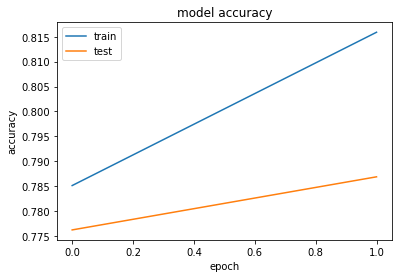

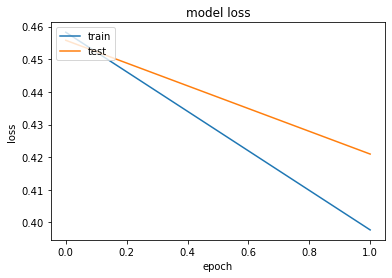

In [27]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
print("Training Output")
print("accuracy: ", history.history['accuracy'])
print("precision: ", history.history['precision'])
print("recall: ", history.history['recall'])
print("loss: ", history.history['loss'])

Training Output
accuracy:  [0.7850932478904724, 0.8159112930297852]
precision:  [0.7644528746604919, 0.8000686764717102]
recall:  [0.8129362463951111, 0.83347487449646]
loss:  [0.45828521251678467, 0.39771127700805664]


In [29]:
print("Validation Output")
print("accuracy: ", evaluation[1])
print("precision: ", evaluation[2])
print("recall: ", evaluation[3])
print("loss: ", evaluation[0])

Validation Output
accuracy:  0.7868494391441345
precision:  0.8719625473022461
recall:  0.6629143357276917
loss:  0.42095473408699036


### Agricultural Label Counts

In [17]:
def count_label(data_gen, batch_count):
    agri_count = 0
    for i in range(batch_count):
        _, label = data_gen.__getitem__(i)
        batch_agri_count = np.sum(label)
        agri_count += batch_agri_count
        if i%1000 == 0:
              print('Agicultural label count in batch ', i, ' is ', batch_agri_count)

    return agri_count

In [18]:
print(BATCH_COUNT)

18447


In [21]:
count_label(data_gen, BATCH_COUNT)

Agicultural label count in batch  0  is  6
Agicultural label count in batch  1000  is  9
Agicultural label count in batch  2000  is  8
Agicultural label count in batch  3000  is  7
Agicultural label count in batch  4000  is  9
Agicultural label count in batch  5000  is  9
Agicultural label count in batch  6000  is  10
Agicultural label count in batch  7000  is  4
Agicultural label count in batch  8000  is  4
Agicultural label count in batch  9000  is  8
Agicultural label count in batch  10000  is  5
Agicultural label count in batch  11000  is  9
Agicultural label count in batch  12000  is  6
Agicultural label count in batch  13000  is  6
Agicultural label count in batch  14000  is  6
Agicultural label count in batch  15000  is  6
Agicultural label count in batch  16000  is  6
Agicultural label count in batch  17000  is  7
Agicultural label count in batch  18000  is  9
Agicultural label count in batch  19000  is  7
Agicultural label count in batch  20000  is  10
Agicultural label count 

289878